<a href="https://colab.research.google.com/github/ghuioio/project3/blob/main/custom_loss_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
pip install yfinance

In [17]:
import numpy as np
np.random.seed(1) # for reproducibility
import keras
import keras.backend as K
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import yfinance as yf
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
hsbc = yf.download('0005.HK', '2000-01-01', '2021-01-01')
hsbc = hsbc.drop(['Adj Close'], axis=1)
hsbc = hsbc.drop(hsbc[hsbc.Volume==0].index)
print(hsbc.head())

[*********************100%***********************]  1 of 1 completed
             Open   High     Low  Close    Volume
Date                                             
2000-01-03  111.0  111.5  107.50  108.0   3908164
2000-01-04  106.0  106.5  105.00  106.0   6895378
2000-01-05  101.0  102.0   99.50  100.5  14657098
2000-01-06  101.0  102.0   96.25   97.0  10632084
2000-01-07   98.5  101.0   97.50  100.5   8368286


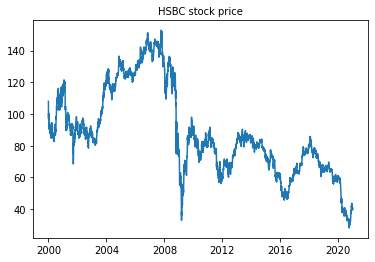

In [19]:
fig, ax1 = plt.subplots()
ax1.set_title('HSBC stock price', fontsize=10)
ax1.plot(hsbc['Close'])
plt.show()

In [20]:
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(hsbc, train_size=0.8, test_size=0.2, shuffle=False)
print("Training data set size -", len(df_train))
print("Test data set size -", len(df_test))


Training data set size - 4140
Test data set size - 1035


In [21]:
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [22]:
#set parameters for model
params = {
    "BATCH_SIZE": 64,
    "EPOCHS": 50,
    "LR": 0.00010000,
    "TIME_STEPS": 60
    }

#path to input & output
PATH_TO_DRIVE = 'YOUR OWN DIRECTORY PATH'
INPUT_PATH = PATH_TO_DRIVE + '\\inputs'
OUTPUT_PATH = PATH_TO_DRIVE  + '\\outputs'
TIME_STEPS = params['TIME_STEPS']
BATCH_SIZE = params['BATCH_SIZE']
stime = time.time()


# check if directory already exists
#if not os.path.exists(OUTPUT_PATH):
#    os.makedirs(OUTPUT_PATH)
#    print("Directory created", OUTPUT_PATH)

#else:
#    raise Exception("Directory already exists. Don't override.")


def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ", np.round(seconds%60),"seconds")

In [23]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [24]:
def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size", x_t.shape, y_t.shape)

Length of inputs 4080
length of time-series - inputs (4080, 60, 5)
length of time-series - outputs (4080,)
Batch trimmed size (4032, 60, 5) (4032,)


In [25]:
def custom_loss(y_true, y_pred):
    
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    # print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.tensor_scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss


In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                    dropout=0.4, recurrent_dropout=0.0,
                    stateful=True, return_sequences=True,
                    kernel_initializer='random_uniform'))
model_lstm.add(LSTM(60, dropout=0.4))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss=custom_loss, optimizer= tf.optimizers.Adam(lr=params["LR"]))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.array_split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.array_split(trim_dataset(y_temp, BATCH_SIZE), 2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

Length of inputs 975
length of time-series - inputs (975, 60, 5)
length of time-series - outputs (975,)
Test size (480, 60, 5) (480,) (480, 60, 5) (480,)


In [28]:
history_lstm = model_lstm.fit(x_t, y_t, epochs=params["EPOCHS"], verbose=0, batch_size=BATCH_SIZE,
                      shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE)),)

In [29]:
y_pred_lstm = model_lstm.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred_lstm = y_pred_lstm.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

error_lstm = mean_squared_error(y_test_t, y_pred_lstm)
print("Error is", error_lstm, y_pred_lstm.shape, y_test_t.shape)
print(y_pred_lstm[0:15])
print(y_test_t[0:15])

y_pred_lstm_org = (y_pred_lstm * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Error is 0.0022752718060499275 (448,) (448,)
[0.26002222 0.2601156  0.26015177 0.26039517 0.26040503 0.26036587
 0.2603268  0.26037967 0.26054317 0.26051104 0.26035726 0.26037908
 0.2604652  0.26052272 0.26065105]
[0.2587646  0.25667779 0.26544242 0.25292152 0.25250417 0.26168612
 0.26627713 0.26502503 0.27128547 0.26544242 0.27045076 0.26335561
 0.26794656 0.26836395 0.26836395]
[64.150665 64.16185  64.16618  64.19534  64.196526 64.19183  64.18715
 64.19348  64.21307  64.20922  64.190796 64.19341  64.203735 64.210625
 64.226   ]
[64.         63.75       64.80000305 63.29999924 63.25       64.34999847
 64.90000153 64.75       65.5        64.80000305 65.40000153 64.55000305
 65.09999847 65.15000153 65.15000153]


Error is 0.49440715883668906


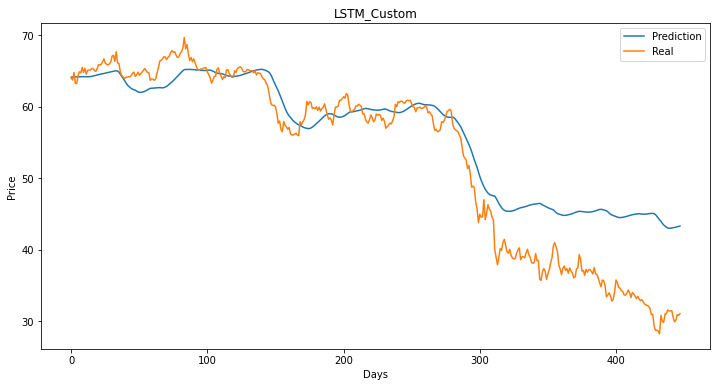

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(y_pred_lstm_org)
plt.plot(y_test_t_org)
plt.title('LSTM_Custom')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred_lstm)-1,))

for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0

error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
print("Error is", error_lstm)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(60,5)))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss=custom_loss, optimizer='adam')

In [33]:
history_cnn = model_cnn.fit(x_t, y_t, epochs=params["EPOCHS"], verbose=0, batch_size=BATCH_SIZE,
                      shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                      trim_dataset(y_val, BATCH_SIZE)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [34]:
y_pred_cnn = model_cnn.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred_cnn = y_pred_cnn.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)

error_cnn = mean_squared_error(y_test_t, y_pred_cnn)
print("Error is", error_cnn, y_pred_cnn.shape, y_test_t.shape)
print(y_pred_cnn[0:15])
print(y_test_t[0:15])

y_pred_cnn_org = (y_pred_cnn * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] 
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] 

print(y_pred_cnn_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0013071455592651372 (448,) (448,)
[0.27167445 0.27269587 0.27378505 0.27436015 0.2739919  0.27295458
 0.27127668 0.2710466  0.27056128 0.27116773 0.26943555 0.26864356
 0.26777315 0.26797277 0.26867795]
[0.2587646  0.25667779 0.26544242 0.25292152 0.25250417 0.26168612
 0.26627713 0.26502503 0.27128547 0.26544242 0.27045076 0.26335561
 0.26794656 0.26836395 0.26836395]
[65.5466   65.66896  65.79945  65.86835  65.824234 65.69996  65.49895
 65.47139  65.41324  65.48589  65.27838  65.1835   65.07922  65.103134
 65.18762 ]
[64.         63.75       64.80000305 63.29999924 63.25       64.34999847
 64.90000153 64.75       65.5        64.80000305 65.40000153 64.55000305
 65.09999847 65.15000153 65.15000153]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Error is 0.48769574944071586 (447,) (447,)
[1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.]
[0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.]


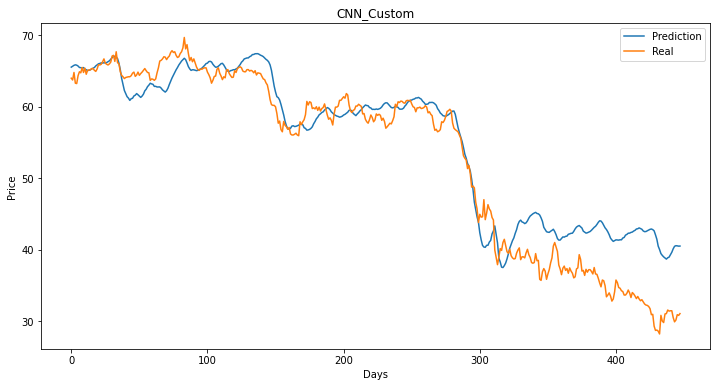

In [35]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(y_pred_cnn_org)
plt.plot(y_test_t_org)
plt.title('CNN_Custom')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='best')

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_cnn_final = np.zeros((len(y_pred_cnn)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_cnn_org)-1):
    if y_pred_cnn_org[i+1] >= y_pred_cnn_org[i]:
        y_pred_cnn_final[i] = 1
    else:
        y_pred_cnn_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


error_cnn = mean_absolute_error(y_test_t_final, y_pred_cnn_final)
print("Error is", error_cnn, y_pred_cnn_final.shape, y_test_t_final.shape)
print(y_pred_cnn_final[0:15])
print(y_test_t_final[0:15])